In [1]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/mnt/d/1ResProj/mob2crime'

In [2]:
import glob
import urllib.request
import unicodedata
import os
import time
import pandas as pd
import geopandas as gp
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
import src.utils.map_vis as mvis

# 2010 census
https://www.inegi.org.mx/programas/ccpv/2010/default.html

## Marco geoestadístico

In [6]:
folder = 'data/mexico/geography-socioeconomics/2010CensusGeography'

### National Geostatistical Framework up to urban AGEB and points of rural localities

Urban localidade polygons and rural ageb points

In [7]:
mge = gp.read_file(f'{folder}/national_macro/mge2010v5_0/estados.shp')

In [8]:
mgm = gp.read_file(f'{folder}/national_macro/mgm2010v5_0/municipios.shp')

In [9]:
mglu = gp.read_file(f'{folder}/national_macro/mglu2010v5_0/poligonos_urbanos.shp')

In [10]:
mglu['loc_id'] = mglu.CVE_ENT+mglu.CVE_MUN+mglu.CVE_LOC

In [11]:
mglu.head()

,CVE_ENT,CVE_MUN,CVE_LOC,NOM_LOC,geometry,loc_id
0,09,012,0027,San Miguel Topilejo,"POLYGON ((2799930.0009 802316.5907999985, 2799...",090120027
1,09,010,0001,Álvaro Obregón,"POLYGON ((2794395.921300001 824857.5522999987,...",090100001
2,09,012,0026,San Miguel Ajusco,"POLYGON ((2795564.199900001 805128.9651000015,...",090120026
3,09,012,0019,Parres (El Guarda),"POLYGON ((2796031.678199999 795559.3674000017,...",090120019
4,09,013,0001,Xochimilco,(POLYGON ((2803142.855099998 803850.4123000018...,090130001


In [12]:
mglr = gp.read_file(f'{folder}/national_macro/mglr2010v5_0/localidades_rurales.shp')
mglr['loc_id'] = mglr.CVE_ENT +mglr.CVE_MUN+mglr.CVE_LOC
mglr['ageb_id'] = mglr.CVE_ENT +mglr.CVE_MUN+mglr.CVE_LOC + mglr.CVE_AGEB

In [13]:
mglr.geometry.apply(lambda x: x.type).unique()

array(['Point'], dtype=object)

In [14]:
mglr[mglr.CVE_ENT=='01'].head()

,CVE_ENT,CVE_MUN,CVE_AGEB,CVE_LOC,NOM_LOC,geometry,loc_id,ageb_id
185716,01,001,106-8,0094,Granja Adelita,POINT (2461579.763943349 1095060.813845353),010010094,010010094106-8
185717,01,001,175-9,0096,Agua Azul,POINT (2463239.900243366 1096403.128981486),010010096,010010096175-9
185718,01,001,175-9,0100,Rancho Alegre,POINT (2461660.447791724 1093132.58397706),010010100,010010100175-9
185719,01,001,112-3,0102,Los Arbolitos [Rancho],POINT (2463239.954425412 1084957.286524462),010010102,010010102112-3
185720,01,001,190-3,0104,Ardillas de Abajo (Las Ardillas),POINT (2480243.672014353 1103103.167053489),010010104,010010104190-3


In [15]:
mglr.groupby('CVE_LOC').CVE_AGEB.size()

CVE_LOC
0001       4
0002    1574
0003    1507
0004    1451
0005    1409
        ... 
7901       1
7902       1
8001       1
8009       1
8010       1
Name: CVE_AGEB, Length: 4601, dtype: int64

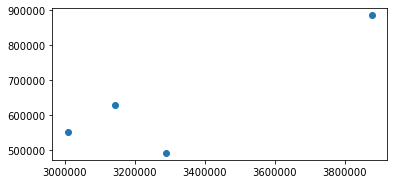

In [16]:
mglr[mglr.CVE_LOC=='0001'].plot()

### Urban Geostatistical Cartography

- link: https://www.inegi.org.mx/app/mapas/?t=0710000000000000&tg=3604
- coverage: 
    - Graphical representation of all the towns with more than 2,500 inhabitants, in addition to the municipal headwaters of the country, existing at the time of the realization of the different census events since 1990, contains street names, location of the main services, the limits of areas Basic urban geostatistics, with their respective identification keys.
    - The set of Urban Localities of the National Territory is constituted by 4,525 localities, corresponding to the closing of the Population and Housing Census 2010, the consultation or download that is provided is for each municipality containing all the localities that conform it.

#### The AGEB within a localidad is almost the same as the whole urban localidad, sometimes it can be large

In [17]:
mglu['mun_id'] = mglu.loc_id.apply(lambda x: x[:5])

In [18]:
mun_ids = mglu.mun_id.unique()

In [78]:
diff_areas = []
for mun_id in mun_ids:
    urb_mun = mglu[mglu.mun_id==mun_id].to_crs(4326).to_crs(mglu.crs)
    urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz').to_crs(mglu.crs)
    urb_ageb['ageb'] = urb_ageb.CVEGEO.apply(lambda x: x[-4:])
    urb_ageb['loc_id'] = urb_ageb.CVEGEO.apply(lambda x: x[:-4])

    urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz').to_crs(mglu.crs)
    urb_mza['loc_id'] = urb_mza.CVEGEO.apply(lambda x: x[:9])
    urb_mza['ageb'] = urb_mza.CVEGEO.apply(lambda x: x[9:13])
    urb_mza['mza'] = urb_mza.CVEGEO.apply(lambda x: x[13:])
    
    for _, urb_loc in urb_mun.iterrows():
        loc_id = urb_loc.loc_id
        diff = urb_loc.geometry - cascaded_union(urb_ageb[urb_ageb.loc_id==loc_id].geometry.tolist())
        diff_areas.append({'mun_id':mun_id, 'loc_id': loc_id, 'diff': diff})
    
    if len(diff_areas) >= 1257:
        break

In [83]:
diff_areas_df = pd.DataFrame(diff_areas)
diff_areas_df['darea'] = diff_areas_df['diff'].apply(lambda x: x.area)

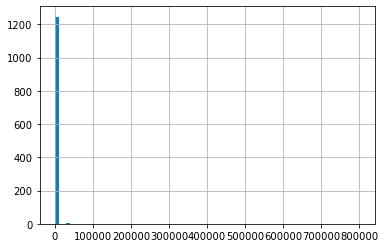

In [105]:
diff_areas_df['darea'].hist(bins=range(-1, 800000, 10000))

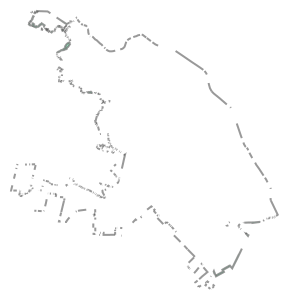

In [90]:
diff_areas_df.loc[1255]['diff']

#### AGEB = MZA + roads + rivers etc

In [86]:
loc_id = '080370001'
mun_id = loc_id[:5]
urb_loc = mglu[mglu.loc_id==loc_id]

urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz')
urb_ageb['ageb'] = urb_ageb.CVEGEO.apply(lambda x: x[-4:])
urb_ageb['loc_id'] = urb_ageb.CVEGEO.apply(lambda x: x[:-4])
urb_ageb_loc = urb_ageb[urb_ageb.loc_id==loc_id].to_crs(mglu.crs)

urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz')
urb_mza['loc_id'] = urb_mza.CVEGEO.apply(lambda x: x[:9])
urb_mza['ageb'] = urb_mza.CVEGEO.apply(lambda x: x[9:13])
urb_mza['mza'] = urb_mza.CVEGEO.apply(lambda x: x[13:])
urb_mza_loc = urb_mza[urb_mza.loc_id==loc_id].to_crs(mglu.crs)


758354.4955077716


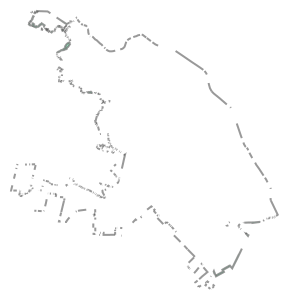

In [93]:
diff = urb_loc.to_crs(epsg=4326).to_crs(mglu.crs).geometry.iloc[0] - cascaded_union(urb_ageb[urb_ageb.loc_id==loc_id].to_crs(mglu.crs).geometry.tolist())
print(diff.area)
diff

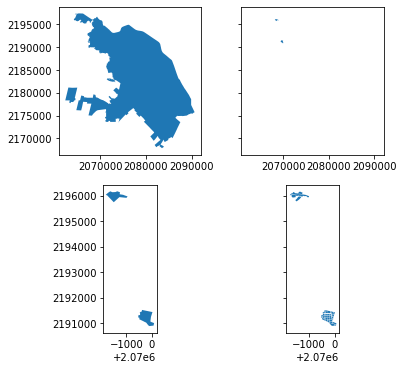

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex='row', sharey='row')
subset = urb_ageb_loc.iloc[:2]
urb_loc.plot(ax=axes[0,0])
subset.plot(ax=axes[1,0])
subset.plot(ax=axes[0,1])
urb_mza_loc[urb_mza_loc.ageb.isin(subset.ageb)].plot(ax=axes[1,1])

### Rural

- Link: https://www.inegi.org.mx/app/mapas/?t=0710000000000000&tg=3595
- coverage: 
    - The Rural Geostatistical Cartography, closing of the Population and Housing Census 2010, is organized in digital archives with alphanumeric and vector information, distributed by federal entities, being understood by locality to any place occupied with one or more buildings used as dwellings, which can be inhabited or not.
    - They contain street names, cultural and natural features (bodies of water), main access roads to the town and the location of the main services (church, school, medical assistance, municipal palace or assistance, market, cemetery and plaza or garden) .
    - The set of Rural Localities of the National Territory is constituted by 48,115 localities, corresponding to the closing of the Population and Housing Census 2010, the consultation or download that is provided is for each municipality containing all the localities that conform it.

#### mglr: point; rural_loc(ageb): polygon, loc>sum(mza)

In [118]:
loc_id = '010030171'
mun_id = loc_id[:5]

rur_loc_in_mg = mglr[mglr.loc_id==loc_id]

rur_ageb = gp.read_file(f'gzip://{folder}/RuralAgeb/{mun_id}.geojson.gz')
rur_ageb['ageb'] = rur_ageb.CVEGEO.apply(lambda x: x[-4:])
rur_ageb['loc_id'] = rur_ageb.CVEGEO.apply(lambda x: x[:-4])
rur_ageb_loc = rur_ageb[rur_ageb.loc_id==loc_id].to_crs(mglr.crs)

rur_mza = gp.read_file(f'gzip://{folder}/RuralMza/{mun_id}.geojson.gz')
rur_mza['loc_id'] = rur_mza.CVEGEO.apply(lambda x: x[:9])
rur_mza['ageb'] = rur_mza.CVEGEO.apply(lambda x: x[9:13])
rur_mza['mza'] = rur_mza.CVEGEO.apply(lambda x: x[13:])
rur_mza_loc = rur_mza[rur_mza.loc_id==loc_id].to_crs(mglr.crs)


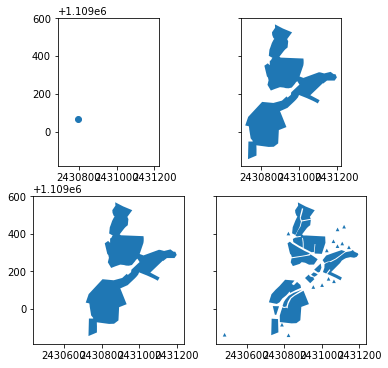

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex='row', sharey='row')
subset = rur_ageb_loc.iloc[:2]
rur_loc_in_mg.plot(ax=axes[0,0])
subset.plot(ax=axes[1,0])
subset.plot(ax=axes[0,1])
rur_mza_loc[rur_mza_loc.ageb.isin(subset.ageb)].plot(ax=axes[1,1])

#### rural loc only has 1 ageb in Poly/multi-Polygons 

In [121]:
rural_ageb_dir = f'{folder}/RuralAgeb'

In [139]:
stats = []
for fn in glob.glob(rural_ageb_dir + '/*'):
    rur_ageb = gp.read_file('gzip://' + fn)
    rur_ageb['loc_id'] = rur_ageb.CVEGEO.apply(lambda x: x[:-4])
    stats.append({
        'mun_id': fn.split('/')[-1][:5],
        'nloc': rur_ageb.loc_id.nunique(),
        'nrow': len(rur_ageb),
        'ncol': rur_ageb.shape[1],
        **rur_ageb.geometry.apply(lambda x: x.type).value_counts().to_dict()
    })


In [141]:
stats = pd.DataFrame(stats)

In [143]:
# each loc id has 1 ageb
(stats.nloc==stats.nrow).mean()

1.0

In [144]:
stats

,mun_id,nloc,nrow,ncol,Polygon,MultiPolygon
0,01001,86,86,12,86.0,NaN
1,01002,47,47,11,47.0,NaN
2,01003,41,41,11,41.0,NaN
3,01004,11,11,11,11.0,NaN
4,01005,45,45,11,45.0,NaN
...,...,...,...,...,...,...
2195,32054,26,26,11,18.0,8.0
2196,32055,32,32,11,29.0,3.0
2197,32056,16,16,11,14.0,2.0
2198,32057,5,5,11,5.0,NaN


#### most rul_loc with poly is in mglr, else only has point repr

In [148]:
loc_ids_with_poly = []

for fn in glob.glob(rural_ageb_dir + '/*'):
    rur_ageb = gp.read_file('gzip://' + fn)
    rur_ageb['loc_id'] = rur_ageb.CVEGEO.apply(lambda x: x[:-4])
    loc_ids_with_poly.extend(rur_ageb.loc_id.tolist())

In [149]:
len(set(mglr.loc_id) - set(loc_ids_with_poly))

139875

In [150]:
loc_id_poly_no_point = set(loc_ids_with_poly) - set(mglr.loc_id)
print(len(loc_id_poly_no_point))
loc_id_poly_no_point.pop()

224


'140780377'

In [210]:
loc_id_poly_no_point = set(loc_id_with_poly) - set(mglr.loc_id)
print(len(loc_id_poly_no_point))
loc_id_poly_no_point.pop()

224


'110410058'

## add population from  


In [23]:
folder_census = 'data/mexico/geography-socioeconomics/2010Census/'

pop_urb_mza = pd.read_csv(f'{folder_census}/urban_mza_pop.csv.gz',dtype={'entidad': str, 'mun': str, 'loc':str, 'ageb':str, 'mza':str})
pop_urb_mza['mza_id'] = pop_urb_mza.entidad + pop_urb_mza.mun+ pop_urb_mza['loc'] + pop_urb_mza.ageb + pop_urb_mza.mza

pop_urb_ageb = pd.read_csv(f'{folder_census}/urban_ageb_pop.csv',dtype={'entidad': str, 'mun': str, 'loc':str, 'ageb':str, 'mza':str})
pop_urb_ageb['ageb_id'] = pop_urb_ageb.entidad + pop_urb_ageb.mun+ pop_urb_ageb['loc'] + pop_urb_ageb.ageb

pop_urb_loc = pop_urb_ageb.groupby(['entidad', 'mun','loc']).pobtot.sum().reset_index()
pop_urb_loc['loc_id'] = pop_urb_loc.entidad + pop_urb_loc.mun+pop_urb_loc['loc']

In [36]:
mun_id = mun_ids[0]

In [59]:
urb_loc_pop = mglu[mglu.mun_id==mun_id].merge(pop_urb_loc, on='loc_id').to_crs(epsg=4326)
total_pop = urb_loc_pop.pobtot.sum()
max_pop = urb_loc_pop.pobtot.max()
urb_loc_pop['pob_pcnt']= urb_loc_pop.pobtot/total_pop
urb_loc_pop['pob_norm']= urb_loc_pop.pobtot/max_pop


In [61]:

urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz')
urb_ageb_pop = urb_ageb.merge(pop_urb_ageb[['ageb_id','pobtot']], left_on='CVEGEO', right_on='ageb_id')
urb_ageb_pop['pob_pcnt']= urb_ageb_pop.pobtot/urb_ageb_pop.pobtot.sum()
urb_ageb_pop['pob_norm']= urb_ageb_pop.pobtot/urb_ageb_pop.pobtot.max()


In [68]:
urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz')
urb_mza_pop = urb_mza.merge(pop_urb_mza[['mza_id','pobtot']], left_on='CVEGEO', right_on='mza_id')
urb_mza_pop['pob_pcnt']= urb_mza_pop.pobtot/urb_mza_pop.pobtot.sum()
urb_mza_pop['pob_norm']= urb_mza_pop.pobtot/urb_mza_pop.pobtot.max()


In [33]:
import folium

In [72]:
folder_census

'data/mexico/geography-socioeconomics/2010Census/'

In [73]:
# plot the vor polygons in cities
m = folium.Map(location=[19.381495, -99.139095], zoom_start=8)

mvis.geojson_per_row_color_col(urb_loc_pop, 'loc', color_col='pob_norm', tip_cols=['loc_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)
mvis.geojson_per_row_color_col(urb_ageb_pop, 'ageb', color_col='pob_norm', tip_cols=['ageb_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)
mvis.geojson_per_row_color_col(urb_mza_pop, 'mza', color_col='pob_norm', tip_cols=['mza_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)

folium.LayerControl().add_to(m)
m.save(folder_census+'20190926Pop_diff_lvl.html')